# Advances in Machine Learning with Big Data

### (part 1 of 2) 
### Trinity 2020 Weeks 1 - 4
### Dr Jeremy Large
#### jeremy.large@economics.ox.ac.uk


&#169; Jeremy Large ; shared under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/)

## 3. Overfit and regularization

## Contents Weeks 1-4:

1. Introducing this course's dataset

1. Being an econometrician _and_ a data scientist

1. **Overfit and regularization**

1. Regularization through predictor/feature selection (Lasso etc.)

1. Resampling methods, and model selection

1. Moving from linear regression to the perceptron

1. Moving from linear regression to the random forest (and similar)

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
plt.rcParams['figure.figsize'] = [12, 4]

import sys, os

import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())
UCI_LIB = os.path.join(REPO_DIR, 'lib')
sys.path.append(UCI_LIB)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np  
import pandas as pd  

In [3]:
#  pull in scikit-learn libraries:
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold

In [4]:
import sbs_sklearn    # module where I've put some functions from the last class

In [5]:
import itertools      # today, we'll use this

### We return to our

### > dataset

### > prediction problem

### > & linear model

**Q.: given the time, date, and complexity of an invoice, what's its expected spend per item shipped?**

In [6]:
# the data:
df, invalids, invoices = sbs_sklearn.get_standard_data()

2020-04-17 14:28:21,173 INFO:Loading C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet Year 2009-2010
2020-04-17 14:28:24,517 INFO:Loaded C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet number one, obviously
2020-04-17 14:30:39,992 INFO:NumExpr defaulting to 8 threads.


In [7]:
#  We build some additional columns in our dataframe to take logs etc.:
invoices['log_item_spend'] = np.log(invoices.invoice_spend / invoices.items_in_invoice)
invoices['log_n_codes'] = np.log(invoices.codes_in_invoice)

In [8]:
predictors = ['log_n_codes', 'hour', 'month', 'words_per_item']

In [9]:
# set out `y` and `X` variables:
y = invoices.log_item_spend
X = invoices[predictors] 

# we'll do 50-fold studies this time:
n_folds = 50

In [10]:
model = linear_model.LinearRegression()

The linear model fits OK with 50-fold testing

[Link to `train_n_test`](https://github.com/jeremy-large/ox-sbs-ml-bd/blob/master/lib/sbs_sklearn.py#L31)

2020-04-17 14:30:51,559 INFO:In study 1/50, train on 20165 points; then test on the other 412: first few test points = [ 69 239 266 309 337] 


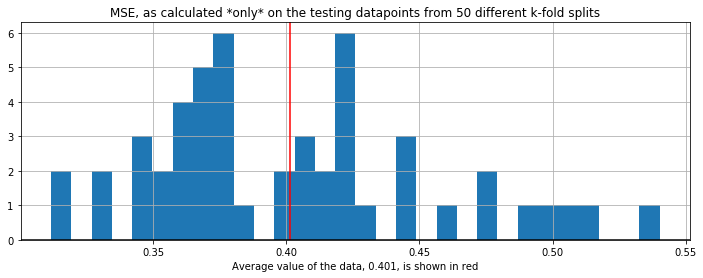

In [11]:
scores = sbs_sklearn.train_n_test(X, y, n_folds, metric=metrics.mean_squared_error)

sbs_sklearn.mfe_r2_diag(scores, metric_name='MSE', histogram=True)

OK, now lets stress-test the linear model:

2020-04-17 14:30:52,074 INFO:In study 1/50, train on 412 points; then test on the other 20165: first few test points = [0 1 2 3 4] 


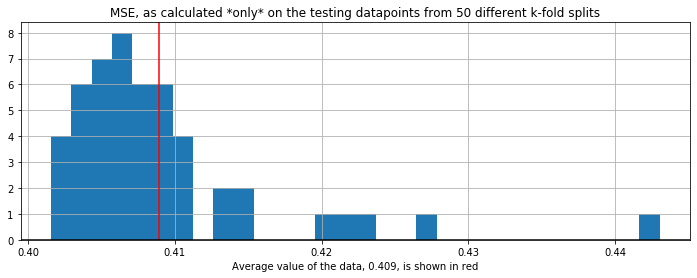

In [12]:
scores = sbs_sklearn.train_n_test(X, y, n_folds, metric=metrics.mean_squared_error, 
                                  train_on_minority=True)   #<< invoke this new option

sbs_sklearn.mfe_r2_diag(scores, metric_name='MSE', histogram=True)

#### Comments:

* our linear model can be fit on a rather small proportion of our dataset

     * not perfectly

* I would say that in part, this is because it is fairly simple and concise

* but this simplicity is tantalising: 

     * could we replace the model with a more complicated one, to get a better MSE?
     

* Extensions to Linear model:

* *Introduction to Statistical Learning* Chapter 3.3.2

### Polynomial Regression:

**Recall our linear setup**: we have an i.i.d. sequence of observations, $\{(y_i, x_i), i=0, 1, ...\}$ where we are interested in moments of the R.V. $y_i$, conditional on the multivariate R.V.  $x_i$ (of length, say, $p$). 

We *postulate* a linear relationship of the following form:

\begin{equation}
y_i = x_i ' \beta + \epsilon_i,
\end{equation}

where $\beta$ is a vector of parameters of length $p$, and the i.i.d. sequence of random variables $\{\epsilon_i\}$ is independent of the regressors $\{x_i\}$

**Perhaps** we are missing interactions or non-linearities. So, lets try augmenting $x_i$ with all possible cross-terms, 

\begin{equation}
\{x_i x_j : i= 0, 1 , ...; j = 0, 1, ...; i \leq j\},
\end{equation} 

... and we can go up to third, and higher orders, so $x_i x_j x_k$, or ... etc.

In [13]:
def build_polynomial_dataframe(data, order):
    """
    @param data: a DataFrame() of features (or regressors)
    @param order: a positive integer - the highest order of polynomial terms to be generated
    @return: a DataFrame() containing data, as well as polynomial terms of that data, up to order 
    
    This function really just *wraps* itertools.combinations_with_replacement()
    """
    poly_data = data.copy()
    for o in range(1, order + 1):
        for tpl in itertools.combinations_with_replacement(data.columns, o):
            name = "_x_".join(tpl)
            poly_data[name] = data[list(tpl)].prod(axis=1)
    return poly_data

What is this `itertools.combinations_with_replacement()`?

 - Always the same answer:
 
 - https://duckduckgo.com/?q=itertools+combinations+with+replacement&ia=web

We'll create polynomials of, say, orders up to 4:

In [14]:
polynomial_X = build_polynomial_dataframe(invoices[predictors], 4)
polynomial_X.shape

(20577, 69)

In [15]:
polynomial_X.head(1).T

Invoice,489434
log_n_codes,2.079442e+00
hour,7.000000e+00
month,2.009120e+05
words_per_item,3.625000e+00
log_n_codes_x_log_n_codes,4.324077e+00
...,...
month_x_month_x_month_x_month,6.070748e+18
month_x_month_x_month_x_words_per_item,2.939853e+16
month_x_month_x_words_per_item_x_words_per_item,5.304296e+11
month_x_words_per_item_x_words_per_item_x_words_per_item,9.570396e+06


In [16]:
y.head(1)

Invoice
489434    1.113165
Name: log_item_spend, dtype: float64

2020-04-17 14:30:53,103 INFO:In study 1/50, train on 20165 points; then test on the other 412: first few test points = [  9 118 153 183 368] 


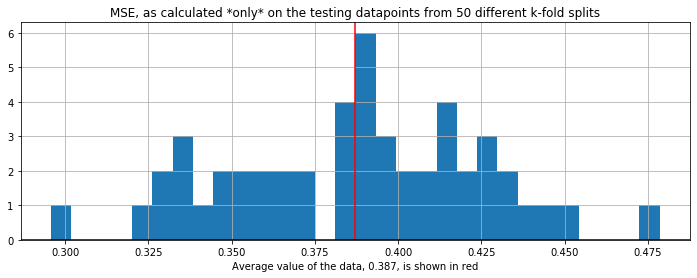

In [17]:
scores = sbs_sklearn.train_n_test(polynomial_X, y, n_folds, metric=metrics.mean_squared_error)

sbs_sklearn.mfe_r2_diag(scores, metric_name='MSE', histogram=True)

This seems to be helping - MSE is best yet, well below 0.4

#### However, the added flexibility comes with a risk:

### The 'jaggedness' of a small dataset is instilled into the fit, causing trouble in test data:

2020-04-17 14:30:57,012 INFO:In study 1/50, train on 412 points; then test on the other 20165: first few test points = [0 1 2 3 4] 


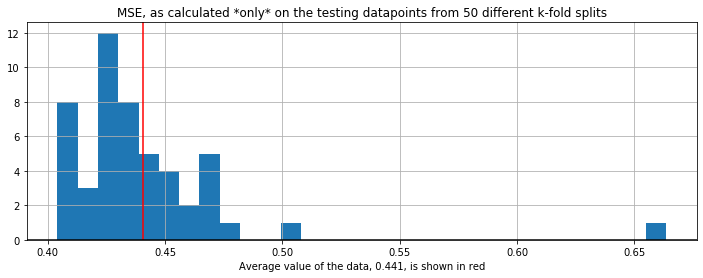

In [18]:
scores = sbs_sklearn.train_n_test(polynomial_X, y, n_folds, metric=metrics.mean_squared_error, 
                                  train_on_minority=True)

sbs_sklearn.mfe_r2_diag(scores, metric_name='MSE', histogram=True)

### Overfitting

The model had better, at least, perform on **test**, or **hold-out** data

Or how could we trust it for future use?

* tight fit on training data but failure on test data
* -> **overfitting**, or - to put it another way -
* poor **bias/variance tradeoff** (*Introduction to Statistical Learning* 2.2.2)

We fit our model to the specific nature ('jaggedness') of the data which we happen to have at hand

Our modelling fails to **generalise** to new cases

There exists a collection of remedies, falling under the term **Regularization** ([-> Wikipedia](https://en.wikipedia.org/wiki/Regularization_(mathematics) ) )



### Regularization

**Background** : when we *fit* a model, we optimize an objective
* recall, MLEs

In the case of regression, we adjust the vector $\beta$ until we have minimized:
\begin{equation}
\sum_{i=0}^N \left(y_i - x_i\beta\right)^2
\end{equation}
Perhaps we can do this analytically, but perhaps (recall ARCH(1, 1) model) we *have* to use numerical minimization

Regularization is the practice of 
  * adjusting this objective, or,
  * constraining our ability to minimize numerically, or
  
  *...
     *  -> in the direction of *simplicity*

#### The central proposal in regularization, is to adjust this *objective function* to **penalize complexity**:

for example,  adjust the vector $\beta$ until we have minimized:

\begin{equation}
\sum_{i=0}^N \left(y_i - x_i\beta\right)^2  +  \beta'W\beta
\end{equation}

**Discussion** : is the weights $W$ a matrix, a vector, or a scalar? Is it constant or random?

If $W >> 0 $, we're going to *tilt* our optimum in the direction of simplicity

* because unimportant elements of $\beta$ are going to be driven towards zero 

-> So, fewer parameters are in play

<-> [Occam's Razor](https://en.wikipedia.org/wiki/Occam%27s_razor)

**Exercise** : consider what $W >> 0$ could/should mean. Can you think of any alternatives to this function of $\beta$ (i.e. to $\beta'W\beta$)?

#### Ridge regression:

[(web search)](https://duckduckgo.com/?t=ffsb&q=ridge+regression&ia=web)

Instead of OLS objective, we adjust the vector $\beta$ to minimize:

\begin{equation}
\sum_{i=0}^N \left(y_i - x_i\beta\right)^2  +  \beta'W\beta
\end{equation}

We have *parameters*, here $\beta$, but we also have *tuning parameters*, here $W$

#### Lets have in mind four alternatives to the *quadratic form* above:

A (Lasso):


\begin{equation}
\sum_{i=0}^N \left(y_i - x_i\beta\right)^2  +  K\sum_{j=0}^p|\beta_j|
\end{equation}

[Original paper](https://www.jstor.org/stable/2346178)

Original formulation (makes no difference): minimize the usual objective, but subject to a constraint: 

\begin{equation}
\sum_{i=0}^N \left(y_i - x_i\beta\right)^2  \text{: subject to } \sum_{j=0}^p|\beta_j| < k
\end{equation}

(where $K$ and $k$ are [related] tuning parameters)

B (Elastic Net):


\begin{equation}
\sum_{i=0}^N \left(y_i - x_i\beta\right)^2  + \alpha k \sum_{j=0}^p|\beta_j| + (1-\alpha) \beta'W\beta
\end{equation}

Nothing especially new - just a mixture of $\alpha$ times Lasso plus $(1-\alpha)$ times Ridge Regression

**Exercise** : which are the *parameters*, which are the *tuning parameters*?

C (Early stopping):

Adjust the vector $\beta$ to minimize:

\begin{equation}
\sum_{i=0}^N \left(y_i - x_i\beta\right)^2  +  \text{increasing penalty for computational time/effort during optimization}
\end{equation}

D (Dropout):

Adjust the vector $\beta$ to minimize:

\begin{equation}
\sum_{i=0}^N \left(y_i - x_i\beta\right)^2  +  \text{increasing penalty for computational time/effort during optimization}
\end{equation}

**subject to** [regular, random 'forgetting'](https://duckduckgo.com/?t=ffsb&q=dropout+regularization&ia=web) of where we'd got to in the numerical progress

(every $n$, say, iterations, reset a random element in the provisional vector $\beta$, to zero)

... and there will be others, e.g. E (Bagging)

#### Rationales for regularization:

- **Theoretical** : We have a prior on the *parameters*. The prior is a distribution. It itself has some parameters. These are the *tuning parameters*. This means we should maximize $log(Pr(\beta)) + log(Lik(\beta; X))$

- **Pragmatic** : doing this improves fit in our particular *test* or *hold-out* dataset (at hand)

 - **Theoretical / pragmatic** : We believe in Occam's Razor. Regularization drives our models in Occam's direction. 

 - **Pragmatic / theoretical** : in our experience, doing this tends to improve fit in our *hold-out data*